In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('student-data.csv')

In [3]:
df.head().T

,0,1,2,3,4
Gender,Male,Male,Male,Male,Female
Age,28,28,25,23,31
Academic Pressure,2.0,4.0,1.0,1.0,1.0
Study Satisfaction,4.0,5.0,3.0,4.0,5.0
Sleep Duration,7-8 hours,5-6 hours,5-6 hours,More than 8 hours,More than 8 hours
Dietary Habits,Moderate,Healthy,Unhealthy,Unhealthy,Healthy
Have you ever had suicidal thoughts ?,Yes,Yes,Yes,Yes,Yes
Study Hours,9,7,10,7,4
Financial Stress,2,1,4,2,2
Family History of Mental Illness,Yes,Yes,No,Yes,Yes


## Data Cleaning

In [4]:
df.isnull().sum()

Gender                                   0
Age                                      0
Academic Pressure                        0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Have you ever had suicidal thoughts ?    0
Study Hours                              0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [5]:
df.dtypes

Gender                                    object
Age                                        int64
Academic Pressure                        float64
Study Satisfaction                       float64
Sleep Duration                            object
Dietary Habits                            object
Have you ever had suicidal thoughts ?     object
Study Hours                                int64
Financial Stress                           int64
Family History of Mental Illness          object
Depression                                object
dtype: object

In [6]:
df.dtypes

Gender                                    object
Age                                        int64
Academic Pressure                        float64
Study Satisfaction                       float64
Sleep Duration                            object
Dietary Habits                            object
Have you ever had suicidal thoughts ?     object
Study Hours                                int64
Financial Stress                           int64
Family History of Mental Illness          object
Depression                                object
dtype: object

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_') # replacing spaces with underscores

In [8]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower()


df = df.rename(columns={'have_you_ever_had_suicidal_thoughts_?': 'suicidal_thoughts'}) # renaming the long heading to something short

df.suicidal_thoughts = (df.suicidal_thoughts == 'yes').astype(int)
df.family_history_of_mental_illness = (df.family_history_of_mental_illness == 'yes').astype(int)
df.depression = (df.depression == 'yes').astype(int)

In [9]:
df.head().T

,0,1,2,3,4
gender,male,male,male,male,female
age,28,28,25,23,31
academic_pressure,2.0,4.0,1.0,1.0,1.0
study_satisfaction,4.0,5.0,3.0,4.0,5.0
sleep_duration,7-8 hours,5-6 hours,5-6 hours,more than 8 hours,more than 8 hours
dietary_habits,moderate,healthy,unhealthy,unhealthy,healthy
suicidal_thoughts,1,1,1,1,1
study_hours,9,7,10,7,4
financial_stress,2,1,4,2,2
family_history_of_mental_illness,1,1,0,1,1


In [10]:
df.sleep_duration.unique()

array(['7-8 hours', '5-6 hours', 'more than 8 hours', 'less than 5 hours'],
      dtype=object)

In [11]:
sleep_duration_labeled = {
    'less than 5 hours': 0,
    '5-6 hours': 1,
    '7-8 hours': 2,
    'more than 8 hours': 3
}



In [12]:
df.sleep_duration = df.sleep_duration.map(sleep_duration_labeled)

In [13]:
df.sleep_duration

0      2
1      1
2      1
3      3
4      3
      ..
497    3
498    0
499    1
500    3
501    3
Name: sleep_duration, Length: 502, dtype: int64

## Splitting Data

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, stratify=df['depression'], random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.3, stratify=df_full_train['depression'], random_state=42)

y_train = df_train.depression.values
y_val = df_val.depression.values
y_test = df_test.depression.values

print(f"Original dataset size: {len(df)}")
print(f"Full Train + Val size: {len(df_full_train)}")
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")


Original dataset size: 502
Full Train + Val size: 401
Train size: 280
Validation size: 121
Test size: 101


To avoid data leakage, I have defined a columns array that excludes our target variable y (depression) when training

In [15]:
df.dtypes

gender                               object
age                                   int64
academic_pressure                   float64
study_satisfaction                  float64
sleep_duration                        int64
dietary_habits                       object
suicidal_thoughts                     int32
study_hours                           int64
financial_stress                      int64
family_history_of_mental_illness      int32
depression                            int32
dtype: object

In [16]:
numerical = ['age', 'academic_pressure', 'study_satisfaction', 
             'suicidal_thoughts', 'study_hours', 'financial_stress', 
             'family_history_of_mental_illness']

categorical = ['gender', 'sleep_duration', 'dietary_habits']

In [17]:
len(df_full_train), len(df_train), len(df_val), len(df_test)

(401, 280, 121, 101)

## Validting the model

In [18]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000, solver='liblinear')
    model.fit(X_train, y_train)
    
    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [21]:
depressed_score = (y_pred >= 0.50)
(y_val == depressed_score).mean()


0.9504132231404959

## Finding the best threshold

In [22]:
thresholds = np.linspace(0, 1, 21)
scores = []
best_threshold = 0
curr_score = 0

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(score)
    print(f'{t:.2f} {score:.4f}')

    if score > curr_score:
        best_threshold = t
        curr_score = score

print(f"Best threshold for this model is: {best_threshold} with the score of: {curr_score}")
    

0.00 0.5041
0.05 0.7603
0.10 0.8099
0.15 0.8347
0.20 0.8678
0.25 0.8926
0.30 0.9174
0.35 0.9256
0.40 0.9256
0.45 0.9339
0.50 0.9504
0.55 0.9669
0.60 0.9504
0.65 0.9587
0.70 0.9421
0.75 0.9256
0.80 0.8843
0.85 0.8595
0.90 0.8264
0.95 0.7686
1.00 0.4959
Best threshold for this model is: 0.55 with the score of: 0.9669421487603306


## Checking ROC Scores, Precision and Recall

In [23]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

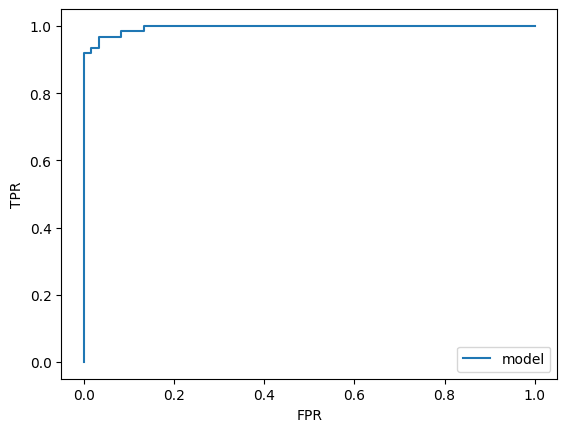

In [24]:
plt.plot(fpr, tpr, label='model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

In [25]:
y_pred_binary = (y_pred >= 0.5).astype(int) 

In [26]:
print(f"Precision: {precision_score(y_val, y_pred_binary)}")
print(f"Recall: {recall_score(y_val, y_pred_binary)}")
print(f"AUC: {roc_auc_score(y_val, y_pred_binary)}")

Precision: 0.9230769230769231
Recall: 0.9836065573770492
AUC: 0.950136612021858


Checking for potential data leakage using correlation

In [27]:
df_train_without_target = df_full_train.drop(columns=['depression'])
df_encoded = pd.get_dummies(df_train_without_target, columns=categorical, drop_first=True)
correlation_with_target = df_encoded.apply(lambda col: col.corr(df_full_train['depression']))
print(correlation_with_target)

age                                -0.209587
academic_pressure                   0.466187
study_satisfaction                 -0.300314
suicidal_thoughts                   0.466569
study_hours                         0.198360
financial_stress                    0.301493
family_history_of_mental_illness    0.042715
gender_male                         0.022358
sleep_duration_1                    0.004476
sleep_duration_2                    0.027489
sleep_duration_3                   -0.052248
dietary_habits_moderate             0.024727
dietary_habits_unhealthy            0.172367
dtype: float64


## K-Fold Validation

- Since our dataset is fairly small in size we will use k-fold for cross validation before training our final model
- Also finding the best regularization parameter for our model

In [28]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

In [29]:
for C in (0.001, 0.01, 0.1, 0.5, 1, 5, 10):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.depression.values
        y_val = df_val.depression.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.838 +- 0.083
C=0.01 0.923 +- 0.045
C=0.1 0.980 +- 0.015
C=0.5 0.995 +- 0.006
C=1 0.996 +- 0.004
C=5 0.998 +- 0.001
C=10 0.999 +- 0.001


In [30]:
dv, model = train(df_train, y_train, C=1)
y_pred = predict(df_val, dv, model)
y_pred_test = predict(df_test, dv, model)

lin_reg_auc_val = roc_auc_score(y_val, y_pred)
lin_reg_auc_test = roc_auc_score(y_test, y_pred_test)
lin_reg_auc_val, lin_reg_auc_test

(0.988686360779384, 0.9996078431372549)

## Testing on other models
- Decision Tree
- Random Forest
- XGBoost

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [33]:
len(list(dv.get_feature_names_out())) # features

13

In [34]:
scores = []

for i in range(1, 10):
    for min_sample_leaf_values in [1, 3, 4, 5, 6, 8, 10, 15]:
        dt = DecisionTreeClassifier(max_depth=i, min_samples_leaf=min_sample_leaf_values)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((i, min_sample_leaf_values, auc))

In [35]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_sample_leaf', 'auc'])
df_scores

,max_depth,min_sample_leaf,auc
0,1,1,0.619107
1,1,3,0.619107
2,1,4,0.619107
3,1,5,0.619107
4,1,6,0.619107
...,...,...,...
67,9,5,0.843809
68,9,6,0.815525
69,9,8,0.831552
70,9,10,0.897549


In [36]:
import seaborn as sns

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

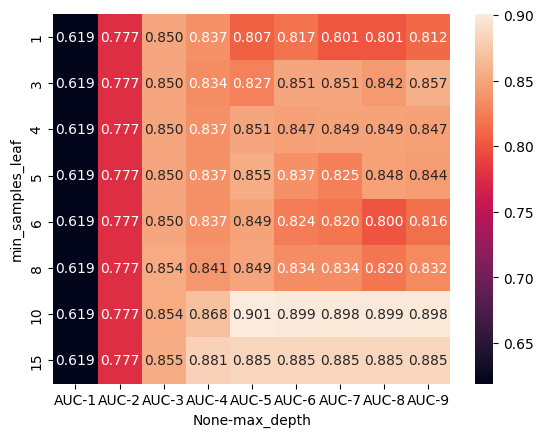

In [37]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'AUC'])
df_scores_pivot = df_scores.pivot(index='min_samples_leaf',
                                 columns=['max_depth'],
                                 values=['AUC'])

sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [38]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
auc_dt_validation = roc_auc_score(y_val, y_pred)
auc_dt_validation

0.9006913890634821

In [39]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_test)[:, 1]
auc_dt_test = roc_auc_score(y_test, y_pred)
auc_dt_test

0.9392156862745098

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.9585166561910747

In [42]:
scores = []

for n in range(10, 301, 10): # going to 200 with 10 steps
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [43]:
df_scores = pd.DataFrame(scores, columns=['n_estimator', 'auc'])

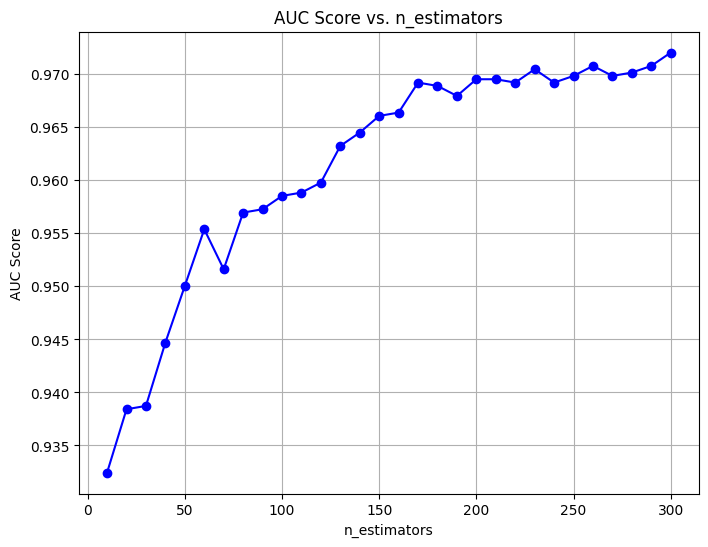

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(df_scores.n_estimator, df_scores.auc, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. n_estimators')
plt.grid(True)

# Show the plot
plt.show()

In [45]:
scores = []

for d in [3, 5, 7, 10, 15]:
    for n in range(10, 201, 10): # going to 200 with 10 steps
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [46]:
df_scores = pd.DataFrame(scores, columns=['depth', 'n_estimator', 'auc'])

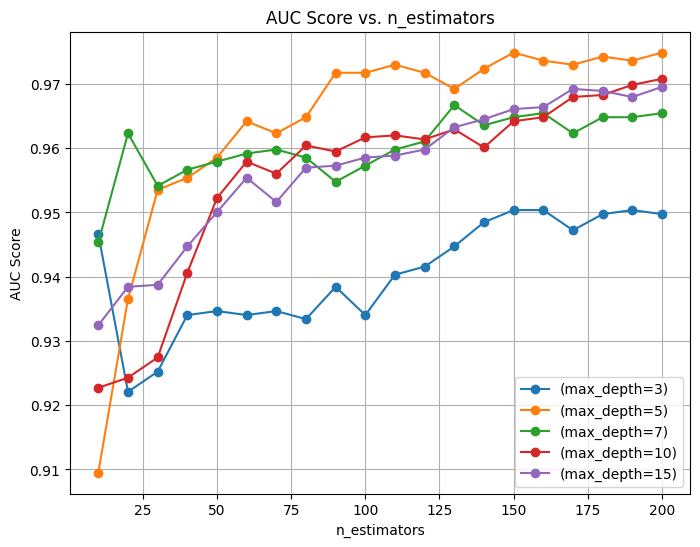

In [47]:
plt.figure(figsize=(8, 6))

for d in [3, 5, 7, 10, 15]:
    df_subset = df_scores[df_scores.depth == d]
    plt.plot(df_subset.n_estimator, df_subset.auc, marker='o', linestyle='-', label=f'(max_depth={d})')

# Adding labels and title
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. n_estimators')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [48]:
max_depth = 5

In [49]:
scores = []

for s in [1, 2, 3, 5, 10, 20, 50]:
    for n in range(10, 201, 10): # going to 200 with 10 steps
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=5,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [50]:
df_scores = pd.DataFrame(scores, columns=['min_sample_leaf', 'n_estimator', 'auc'])

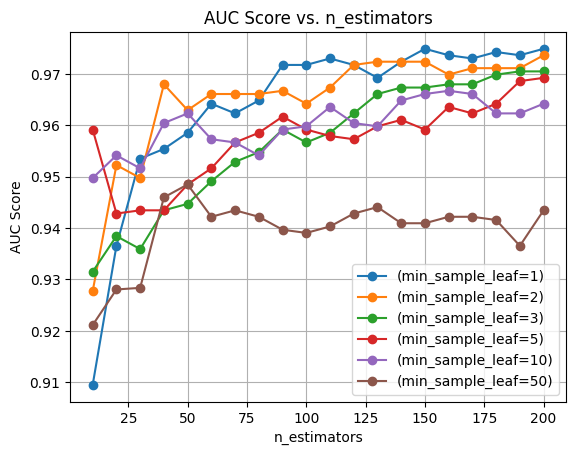

In [51]:

for s in [1, 2, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_sample_leaf == s]
    plt.plot(df_subset.n_estimator, df_subset.auc, marker='o', linestyle='-', label=f'(min_sample_leaf={s})')

# Adding labels and title
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.title('AUC Score vs. n_estimators')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

- Max_depth =5
- N_estimators = 150
- min_sample_leaf = 1

In [52]:
rf = RandomForestClassifier(n_estimators=150, 
                            max_depth=5,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
auc_rf_validation = roc_auc_score(y_val, y_pred)
auc_rf_validation

0.9748585795097423

In [53]:
rf = RandomForestClassifier(n_estimators=150, 
                            max_depth=5,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_test)[:, 1]
auc_rf_test = roc_auc_score(y_test, y_pred)
auc_rf_test

0.9811764705882353

## XGBoost 

In [54]:
import xgboost as xgb

In [55]:
features_name = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_name)

In [56]:
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'nthread': 4, # number of CPU cores to use

    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10) # 200 or 15 ? more trees = risk of overfitting

In [57]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.9528598365807668

In [58]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [59]:
def parse_xgb_output(output):
    results = []

    for data in output.stdout.strip().split('\n'):
        n_iter, train_auc, val_auc = data.split('\t')

        n_iter = int(n_iter.strip('[]'))
        train_auc = float(train_auc.split(':')[1])
        val_auc = float(val_auc.split(':')[1])

        results.append((n_iter, train_auc, val_auc))

            
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_res = pd.DataFrame(results, columns=columns)
       
    return df_res
        

In [60]:
%%capture output

# captures the ouput in the output variable

xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'eval_metric': 'auc',
    
    'nthread': 4, # number of CPU cores to use
    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200) # 200 or 15 ? more trees = risk of overfitting

In [61]:
df_result = parse_xgb_output(output)
df_result

,num_iter,train_auc,val_auc
0,0,0.96069,0.87932
1,5,0.99973,0.94909
2,10,1.00000,0.95035
3,15,1.00000,0.95349
4,20,1.00000,0.95663
5,25,1.00000,0.96103
6,30,1.00000,0.96480
7,35,1.00000,0.96480
8,40,1.00000,0.96543
9,45,1.00000,0.96920


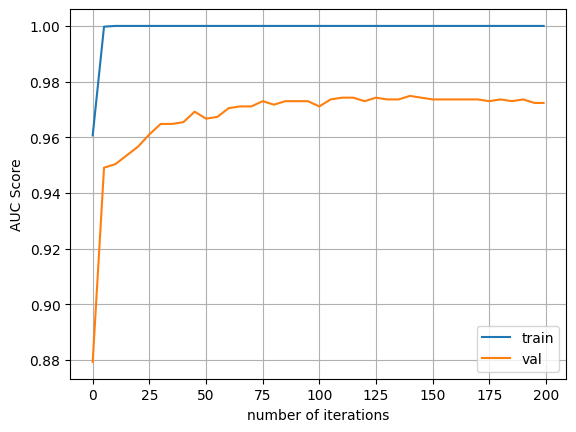

In [62]:
plt.plot(df_result.num_iter, df_result.train_auc, label='train')
plt.plot(df_result.num_iter, df_result.val_auc, label='val')
plt.xlabel('number of iterations')
plt.ylabel('AUC Score')
plt.grid(True)
plt.legend()
plt.show()

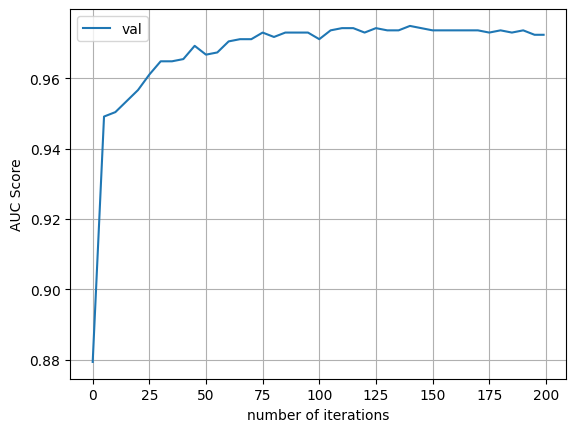

In [63]:
# plt.plot(df_result.num_iter, df_result.train_auc, label='train')
plt.plot(df_result.num_iter, df_result.val_auc, label='val')
plt.xlabel('number of iterations')
plt.ylabel('AUC Score')
plt.grid(True)
plt.legend()
plt.show()

In [64]:
scores = {}

In [65]:
%%capture output

# captures the ouput in the output variable

xgb_params = {
    'eta': 1.0, # learning rate
    'max_depth': 6,
    'min_child_weight': 1, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'eval_metric': 'auc',
    
    'nthread': 4, # number of CPU cores to use
    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200) # 200 or 15 ? more trees = risk of overfitting

In [66]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)
key

'eta=1.0'

In [67]:
scores.keys()

dict_keys(['eta=1.0'])

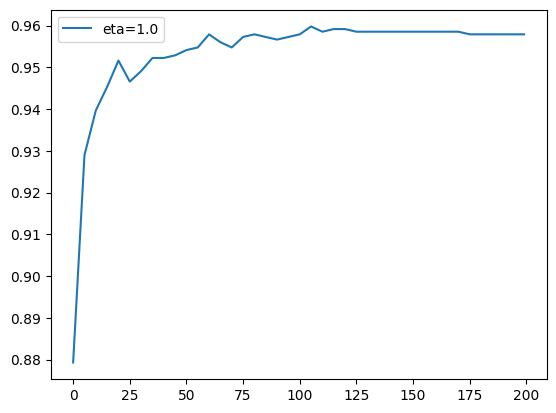

In [68]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.legend()

Tuning `max_depth`

In [69]:
scores = {}

In [70]:
%%capture output

# captures the ouput in the output variable

xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 3,
    'min_child_weight': 1, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'eval_metric': 'auc',
    
    'nthread': 4, # number of CPU cores to use
    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200) # 200 or 15 ? more trees = risk of overfitting

In [71]:
key = f"max_depth={xgb_params['max_depth']}"
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [72]:
scores.keys()

dict_keys(['max_depth=3'])

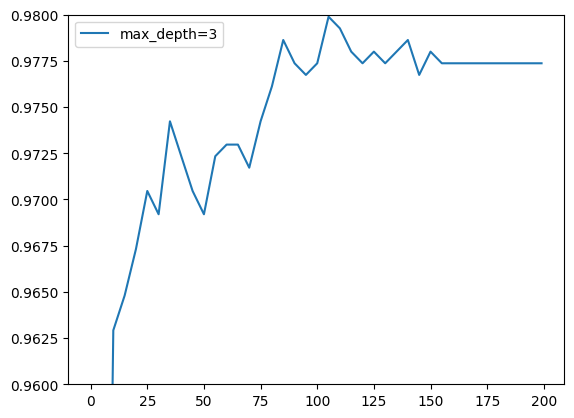

In [73]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.ylim(0.96, 0.98)
plt.legend()

`max_depth = 3`

Tuning `min_child_weight`

In [74]:
scores = {}

In [75]:
%%capture output

# captures the ouput in the output variable

xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 3,
    'min_child_weight': 3, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'eval_metric': 'auc',
    
    'nthread': 4, # number of CPU cores to use
    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain,
                  verbose_eval=5,
                  evals=watchlist,
                  num_boost_round=200) # 200 or 15 ? more trees = risk of overfitting

In [76]:
key = f"min_child_weight={xgb_params['min_child_weight']}"
scores[key] = parse_xgb_output(output)
key

'min_child_weight=3'

In [77]:
scores.keys()

dict_keys(['min_child_weight=3'])

In [ ]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)
plt.ylim(0.96, 0.98)
plt.legend()

In [79]:
%%capture output

# captures the ouput in the output variable

xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 3,
    'min_child_weight': 1, # min_sample_leaf

    'objective': 'binary:logistic', # defining our task whether binary, linear or whatsoever - binary = binary classification, logistic = regression
    'eval_metric': 'auc',
    
    'nthread': 4, # number of CPU cores to use
    'seed': 1, # random_seed
    'verbosity': 1, # for displaying info or warnings
}

model = xgb.train(xgb_params, dtrain, num_boost_round=125) 

In [80]:
dval = xgb.DMatrix(X_val, feature_names=features_name)
dtest = xgb.DMatrix(X_test, feature_names=features_name)

In [81]:
y_pred = model.predict(dval)
xgb_auc_validation = roc_auc_score(y_val, y_pred)
xgb_auc_validation

0.9773727215587681

In [82]:
y_pred = model.predict(dtest)
xgb_auc_test = roc_auc_score(y_test, y_pred)
xgb_auc_test

0.9925490196078431

## Comparing final models

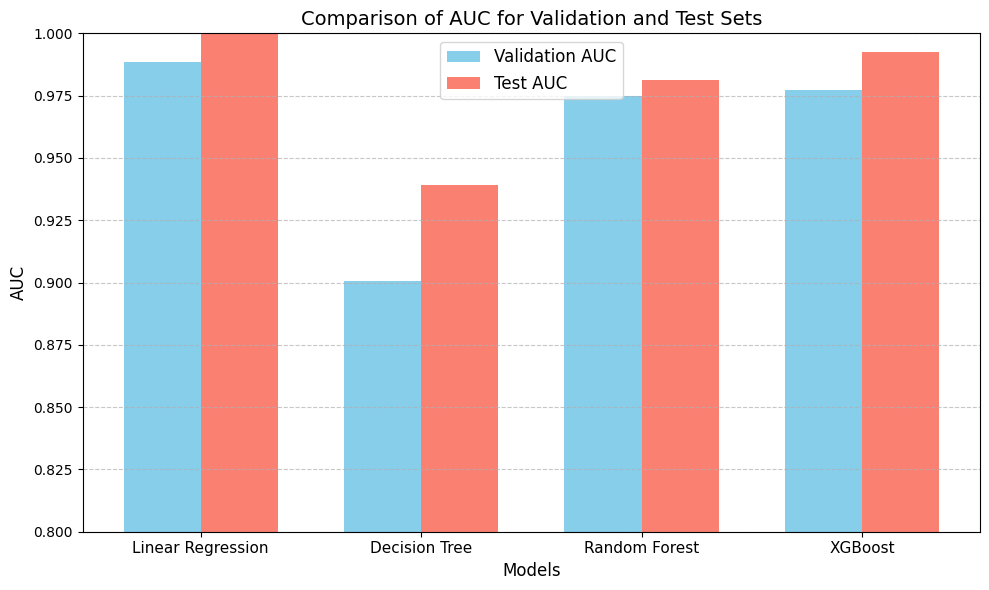

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: AUC values for models
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']  # Model names
val_aucs = [lin_reg_auc_val, auc_dt_validation, auc_rf_validation, xgb_auc_validation]               # Validation AUCs
test_aucs = [lin_reg_auc_test, auc_dt_test, auc_rf_test, xgb_auc_test]              # Test AUCs

# Bar width
bar_width = 0.35
x = np.arange(len(models))  # Position of models on x-axis

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width / 2, val_aucs, bar_width, label='Validation AUC', color='skyblue')
plt.bar(x + bar_width / 2, test_aucs, bar_width, label='Test AUC', color='salmon')

# Adding details
plt.xlabel('Models', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('Comparison of AUC for Validation and Test Sets', fontsize=14)
plt.xticks(x, models, fontsize=11)
plt.ylim(0.8, 1)  # Adjust y-axis for better visualization
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [84]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']  # Model names
val_aucs = [lin_reg_auc_val, auc_dt_validation, auc_rf_validation, xgb_auc_validation]               # Validation AUCs
test_aucs = [lin_reg_auc_test, auc_dt_test, auc_rf_test, xgb_auc_test]              # Test AUCs

print(models, val_aucs, test_aucs)

['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'] [0.988686360779384, 0.9006913890634821, 0.9748585795097423, 0.9773727215587681] [0.9996078431372549, 0.9392156862745098, 0.9811764705882353, 0.9925490196078431]
